In [40]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib as plt
import datetime
import random
import numpy as np

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

plt.rcParams['figure.facecolor'] = 'white'


In [41]:
df = pd.read_csv("newly_confirmed_cases_daily.csv")
df = df[["Date", "Tokyo"]]
df['Date'] = pd.to_datetime(df['Date'])

df['day_of_week'] = df['Date'].dt.day_name()
df = pd.concat([df, pd.get_dummies(df['day_of_week'])], axis=1)
df['prev'] = df['Tokyo'].shift(7)
df = df.iloc[7:].reset_index()
df = df.rename(columns={"Tokyo": "current"})
df["day_of_week_index"] = df["day_of_week"].map({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4,"Friday": 5, "Saturday": 6, "Sunday": 7 })
df.head(10)

,index,Date,current,day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,prev,day_of_week_index
0,7,2020-01-23,0,Thursday,0,0,0,0,1,0,0,0.0,4
1,8,2020-01-24,1,Friday,1,0,0,0,0,0,0,0.0,5
2,9,2020-01-25,1,Saturday,0,0,1,0,0,0,0,0.0,6
3,10,2020-01-26,0,Sunday,0,0,0,1,0,0,0,0.0,7
4,11,2020-01-27,0,Monday,0,1,0,0,0,0,0,0.0,1
5,12,2020-01-28,0,Tuesday,0,0,0,0,0,1,0,0.0,2
6,13,2020-01-29,0,Wednesday,0,0,0,0,0,0,1,0.0,3
7,14,2020-01-30,1,Thursday,0,0,0,0,1,0,0,0.0,4
8,15,2020-01-31,0,Friday,1,0,0,0,0,0,0,1.0,5
9,16,2020-02-01,0,Saturday,0,0,1,0,0,0,0,1.0,6


### EDA

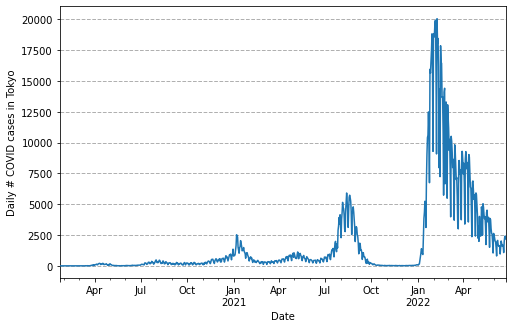

In [42]:
ax = df.set_index("Date")["current"].plot(kind="line", figsize=(8,5), zorder=3)
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=1, zorder=0)
ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Daily # COVID cases in Tokyo', fontsize=10)
ax.figure.savefig('daily_1.png', bbox_inches='tight')

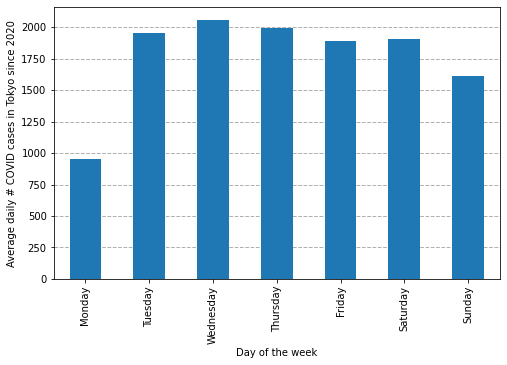

In [43]:
ax = df.groupby("day_of_week").mean().sort_values("day_of_week_index")["current"].plot(kind="bar", figsize=(8,5), zorder=3)
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=1, zorder=0)
ax.set_xlabel('Day of the week', fontsize=10)
ax.set_ylabel('Average daily # COVID cases in Tokyo since 2020', fontsize=10)
ax.figure.savefig('daily_2.png', bbox_inches='tight')

In [44]:
df = df[["Date", 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',  'Saturday', 'Sunday','prev','current']]
df = df.rename(columns= {"prev": "No of Cases - 1 week ago", "current": "No of Cases - Current"})
df["No of Cases - 1 week ago"] = df["No of Cases - 1 week ago"].astype(int)
xs = ['No of Cases - 1 week ago', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',  'Saturday', 'Sunday']
ys = ["No of Cases - Current"]
df

,Date,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,No of Cases - 1 week ago,No of Cases - Current
0,2020-01-23,0,0,0,1,0,0,0,0,0
1,2020-01-24,0,0,0,0,1,0,0,0,1
2,2020-01-25,0,0,0,0,0,1,0,0,1
3,2020-01-26,0,0,0,0,0,0,1,0,0
4,2020-01-27,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
880,2022-06-21,0,1,0,0,0,0,0,1528,1963
881,2022-06-22,0,0,1,0,0,0,0,2015,2329
882,2022-06-23,0,0,0,1,0,0,0,1819,2413
883,2022-06-24,0,0,0,0,1,0,0,1596,2181


### Linear Regression

In [45]:
X = df[xs]
y = df[ys]

exog = sm.add_constant(X)
est = sm.OLS(y, exog).fit()

print(est.summary())

                              OLS Regression Results                             
Dep. Variable:     No of Cases - Current   R-squared:                       0.878
Model:                               OLS   Adj. R-squared:                  0.877
Method:                    Least Squares   F-statistic:                     898.2
Date:                   Mon, 04 Jul 2022   Prob (F-statistic):               0.00
Time:                           12:41:53   Log-Likelihood:                -7540.2
No. Observations:                    885   AIC:                         1.510e+04
Df Residuals:                        877   BIC:                         1.513e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

### Multilayer perceptron

In [46]:
class mlp(torch.nn.Module):
    def __init__(self, input, hidden):
        super(mlp, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(input, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1))

    def forward(self, x):
        x = self.classifier(x)
        return x

def train(optimizer, model, criterion, inputs, labels):
    model.train()
    optimizer.zero_grad()
    pred = model(inputs)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        pred = model(inputs)
        r2 = r2_score(labels, pred)
        return r2 

In [47]:
model = mlp(len(xs), 32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # optimizer: adam optimizer
criterion = torch.nn.MSELoss() # loss: mean squared error loss

train_df, test_df = train_test_split(df, test_size=0.2)
train_x = torch.tensor(train_df[xs].values).float()
train_y = torch.tensor(train_df[ys].values).float()
test_x = torch.tensor(test_df[xs].values).float()
test_y = torch.tensor(test_df[ys].values).float()
mlp_data = []
for epoch in range(1, 101): # Train the algorithm 500 epochs
    loss = train(optimizer, model, criterion, train_x, train_y) 
    r2 = test(model, test_x, test_y ) # At the end of the algorithm, test the model and get r2
    mlp_data.append([epoch, loss, r2])
    print(epoch, loss, r2)

1 15831297.0 -0.17317179051214504
2 14809282.0 -0.09303477450162134
3 13795535.0 -0.0031073109540711297
4 12659058.0 0.10306811936071325
5 11319028.0 0.22540193077739723
6 9778045.0 0.3591129051058596
7 8098401.0 0.498935118818575
8 6349353.0 0.6361713255354176
9 4644339.5 0.7584713471916594
10 3143844.25 0.849415049525179
11 2060189.875 0.8904209238649617
12 1631366.75 0.8694633239243704
13 2006033.75 0.8062901554670034
14 2907042.0 0.7493893413903225
15 3692777.25 0.7344179508069864
16 3897738.0 0.7590910505432432
17 3559590.75 0.8033166803998126
18 2948389.5 0.8470435213962291
19 2332442.75 0.8775706853836778
20 1883250.25 0.8906114284081281
21 1661760.0 0.8882949051459428
22 1644271.125 0.8760823273133853
23 1762452.25 0.860017756779229
24 1939181.75 0.8450457960484059
25 2110675.75 0.8343950467226797
26 2234823.5 0.8296299183467739
27 2290786.5 0.8309678214396397
28 2275052.75 0.8376266124019586
29 2197020.5 0.8491880914217861
30 2062893.25 0.8625011156952975
31 1911282.625 0.8753

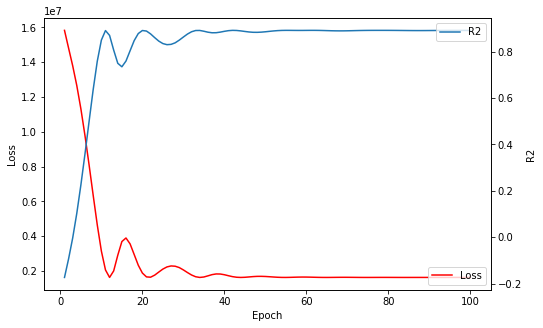

In [48]:
mlp_df = pd.DataFrame(mlp_data, columns=['epoch', "Loss", "R2"])
mlp_df
ax = mlp_df.set_index("epoch")[["Loss"]].plot(kind="line", figsize=(8,5), zorder=3, color="r")
ax1 = ax.twinx()
mlp_df.plot('epoch','R2',ax=ax1)
ax.legend(loc="lower right")
ax1.legend(loc="upper right")
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('Loss', fontsize=10)
ax1.set_ylabel('R2', fontsize=10)

ax.figure.savefig('loss_mlp.png', bbox_inches='tight')

### LSTM

In [49]:
class lstm(torch.nn.Module):
    def __init__(self, input, hidden):
        super(lstm, self).__init__()

        self.classifier = nn.Sequential(
            nn.LSTM(input, hidden),
            nn.Linear(hidden, 1))

    def forward(self, x):
        x = self.classifier(x)
        return x

def train(optimizer, model, criterion, inputs, labels):
    model.train()
    optimizer.zero_grad()
    pred = model(inputs)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        pred = model(inputs)
        r2 = r2_score(labels, pred)
        return r2 

In [50]:
model = mlp(len(xs), 32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # optimizer: adam optimizer
criterion = torch.nn.MSELoss() # loss: mean squared error loss

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
train_x = torch.tensor(train_df[[i for i in xs]].values).float()
train_y = torch.tensor(train_df[ys].values).float()
test_x = torch.tensor(test_df[[i for i in xs]].values).float()
test_y = torch.tensor(test_df[ys].values).float()
lstm_data = []

for epoch in range(1, 101): # Train the algorithm 500 epochs
    loss = train(optimizer, model, criterion, train_x, train_y) 
    r2 = test(model, test_x, test_y ) # At the end of the algorithm, test the model and get r2
    lstm_data.append([epoch, loss, r2])
    print(epoch, loss, r2)

1 1274224.5 -1.6124998359077245
2 1170764.625 -1.4331875604895044
3 1090847.25 -1.2587267985864883
4 1013139.25 -1.058154551958535
5 923819.0 -0.8274531796743836
6 821101.8125 -0.5674903787250392
7 705457.5 -0.2885487261285664
8 581534.0 -0.0025724386089318596
9 454702.15625 0.27348321664424013
10 332613.84375 0.5126713910126601
11 227395.796875 0.6803202057262063
12 154622.921875 0.7388824877496138
13 131093.859375 0.6708537948150862
14 164424.265625 0.5269722552126488
15 231291.609375 0.41561365785055104
16 282537.4375 0.3968355187285426
17 291158.5 0.4572595544416437
18 263403.84375 0.5536169799465752
19 218989.828125 0.6455105582533476
20 176314.421875 0.7083223977085694
21 146640.21875 0.7365615795515105
22 132558.46875 0.7350691811534926
23 131988.5 0.7145508032663128
24 140173.9375 0.6864405474907804
25 151999.078125 0.6603195158727146
26 163095.796875 0.6457547673016256
27 169324.109375 0.6441907023582739
28 169928.28125 0.6566711100337932
29 164550.34375 0.6779175365222415
30 

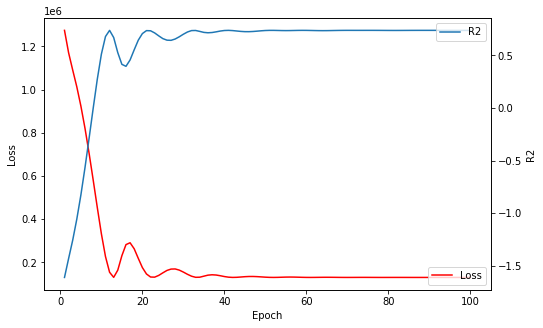

In [51]:
lstm_df = pd.DataFrame(lstm_data, columns=['epoch', "Loss", "R2"])
lstm_df
ax = lstm_df.set_index("epoch")[["Loss"]].plot(kind="line", figsize=(8,5), zorder=3, color="r")
ax1 = ax.twinx()
lstm_df.plot('epoch','R2',ax=ax1)
ax.legend(loc="lower right")
ax1.legend(loc="upper right")
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('Loss', fontsize=10)
ax1.set_ylabel('R2', fontsize=10)

ax.figure.savefig('loss_lstm.png', bbox_inches='tight')